<a href="https://colab.research.google.com/github/soukainaelhanafi/Opinion-mining-/blob/main/Sentiment_Analysis_Covid_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importation des modules

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import re
import string
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')
!pip install neattext
import neattext.functions as nfx
!pip install  nltk                                                              
from nltk.corpus import wordnet
from collections import Counter
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
import plotly.express as px
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn import tree 
from sklearn.naive_bayes import MultinomialNB
from gensim.models import Word2Vec
from gensim.models import FastText
sns.set(style="darkgrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


###Importation du jeu de données

In [ ]:
df_2020 = pd.read_csv('https://raw.githubusercontent.com/gabrielpreda/covid-19-tweets/master/covid19_tweets.csv')

In [ ]:
df_2021 = pd.read_csv('/content/covid19_tweets_2021.csv')

*Afficher les dimensions des deux datasets*

In [ ]:
print(df_2020.shape)
print(df_2021.shape)

(179108, 13)
(15000, 13)


Sélectionnons les colonnes nécessaires à notre projet (user name , date , text )

In [ ]:
df_2020 = df_2020[['user_name','text','date']]
df_2021 = df_2021[['username','text','date']]


*Vérifions les détails du dataframe*

In [ ]:
df_2020.head()


,user_name,text,date
0,ᏉᎥ☻լꂅϮ,If I smelled the scent of hand sanitizers toda...,2020-07-25 12:27:21
1,Tom Basile 🇺🇸,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,2020-07-25 12:27:17
2,Time4fisticuffs,@diane3443 @wdunlap @realDonaldTrump Trump nev...,2020-07-25 12:27:14
3,ethel mertz,@brookbanktv The one gift #COVID19 has give me...,2020-07-25 12:27:10
4,DIPR-J&K,25 July : Media Bulletin on Novel #CoronaVirus...,2020-07-25 12:27:08


In [ ]:
df_2021.head()

,username,text,date
0,GenerasiYeremia,@TheBelieverJC Amen\n\n#Akhirzaman\n#Endtimes\...,2021-08-11 17:49:40
1,CuyahogaOEM,Our new vaccine provider tool shows locations ...,2021-09-16 16:54:35
2,GenerasiYeremia,Amen\n\n#Akhirzaman\n#Endtimes\n#BibleProphecy...,2021-02-25 03:35:11
3,NoumaanMuhamma1,2020 shouldn't be include to our age\n\n#COVID19,2021-04-24 08:04:37
4,viralvideovlogs,My friend's dad recently tested positive. Inte...,2021-01-11 13:26:12


*Changer le nom de la colonne user_name*

In [ ]:
df_2020.rename(columns={"user_name": "username"},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Creation d'un dataset df à partir des deux datasets

In [ ]:
df = pd.concat([df_2020,df_2021], ignore_index=True)

In [ ]:
df.tail()

,username,text,date
194103,lisa_heslep,Joe Biden's immediate #coronavirus priorities ...,2021-10-30 12:53:27
194104,yambarnlagos1,Happy New week from YamBarn... \n#MondayMotiva...,2021-06-11 06:54:02
194105,yambarnlagos1,Happy New week from YamBarn... \n#MondayMotiva...,2021-07-01 13:55:48
194106,amstanley,New Brunswick struggles to contain latest surg...,2021-02-18 01:25:43
194107,yambarnlagos1,Happy New week from YamBarn... \n#MondayMotiva...,2021-04-03 19:14:26


Modifier le type de certaines colonnes

In [ ]:
df.username = df.username.astype('category')
df.username = df.username.cat.codes 
df.date = pd.to_datetime(df.date).dt.date
df.head()

,username,text,date
0,96264,If I smelled the scent of hand sanitizers toda...,2020-07-25
1,79755,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,2020-07-25
2,79481,@diane3443 @wdunlap @realDonaldTrump Trump nev...,2020-07-25
3,89034,@brookbanktv The one gift #COVID19 has give me...,2020-07-25
4,19179,25 July : Media Bulletin on Novel #CoronaVirus...,2020-07-25


*Suppression des tweets dupliqués*

In [ ]:
df.drop_duplicates(subset="text",inplace=True)
df.shape
df.reset_index(drop=True,inplace=True)
df.shape

(182615, 3)

### Choisir les textes du tweet

In [ ]:
texts = df['text']
texts

0         If I smelled the scent of hand sanitizers toda...
1         Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2         @diane3443 @wdunlap @realDonaldTrump Trump nev...
3         @brookbanktv The one gift #COVID19 has give me...
4         25 July : Media Bulletin on Novel #CoronaVirus...
                                ...                        
182610    How does the #coronavirus enter and replicate ...
182611    As I watch @DrFaucis1 I am thinking how happy ...
182612    Are you a newcomer to 🇨🇦? To help prevent furt...
182613    Indian Economy May Grow Moderately in the Comi...
182614    Nifty Slumped on Negative Global Cues Amid Dou...
Name: text, Length: 182615, dtype: object

### Supprimer les URL des tweets

In [ ]:
url_rm = lambda x:re.sub(r'https\S+','',str(x))
texts_rl = texts.apply(url_rm)
texts_rl

0         If I smelled the scent of hand sanitizers toda...
1         Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2         @diane3443 @wdunlap @realDonaldTrump Trump nev...
3         @brookbanktv The one gift #COVID19 has give me...
4         25 July : Media Bulletin on Novel #CoronaVirus...
                                ...                        
182610    How does the #coronavirus enter and replicate ...
182611    As I watch @DrFaucis1 I am thinking how happy ...
182612    Are you a newcomer to 🇨🇦? To help prevent furt...
182613    Indian Economy May Grow Moderately in the Comi...
182614    Nifty Slumped on Negative Global Cues Amid Dou...
Name: text, Length: 182615, dtype: object

### Convertir tous les tweets en minuscules

In [ ]:
to_lower = lambda x : x.lower()
texts_lower = texts_rl.apply(to_lower)
texts_lower

0         if i smelled the scent of hand sanitizers toda...
1         hey @yankees @yankeespr and @mlb - wouldn't it...
2         @diane3443 @wdunlap @realdonaldtrump trump nev...
3         @brookbanktv the one gift #covid19 has give me...
4         25 july : media bulletin on novel #coronavirus...
                                ...                        
182610    how does the #coronavirus enter and replicate ...
182611    as i watch @drfaucis1 i am thinking how happy ...
182612    are you a newcomer to 🇨🇦? to help prevent furt...
182613    indian economy may grow moderately in the comi...
182614    nifty slumped on negative global cues amid dou...
Name: text, Length: 182615, dtype: object

### Suppression des ponctuations

In [ ]:
ponc_rm = lambda x : x.translate(str.maketrans('','',string.punctuation))
texts_ponc = texts_lower.apply(ponc_rm)
texts_ponc

0         if i smelled the scent of hand sanitizers toda...
1         hey yankees yankeespr and mlb  wouldnt it have...
2         diane3443 wdunlap realdonaldtrump trump never ...
3         brookbanktv the one gift covid19 has give me i...
4         25 july  media bulletin on novel coronavirusup...
                                ...                        
182610    how does the coronavirus enter and replicate i...
182611    as i watch drfaucis1 i am thinking how happy i...
182612    are you a newcomer to 🇨🇦 to help prevent furth...
182613    indian economy may grow moderately in the comi...
182614    nifty slumped on negative global cues amid dou...
Name: text, Length: 182615, dtype: object

### Suppression des stopwords

In [ ]:
words = ['covid','#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19']
stop_words = set(words)
stop_words.update(words)

words_rm = lambda x : ' '.join([word for word in x.split() if word not in stop_words])
texts_words = texts_ponc.apply(words_rm)
texts_words


0         if i smelled the scent of hand sanitizers toda...
1         hey yankees yankeespr and mlb wouldnt it have ...
2         diane3443 wdunlap realdonaldtrump trump never ...
3         brookbanktv the one gift has give me is an app...
4         25 july media bulletin on novel coronavirusupd...
                                ...                        
182610    how does the enter and replicate in cells a te...
182611    as i watch drfaucis1 i am thinking how happy i...
182612    are you a newcomer to 🇨🇦 to help prevent furth...
182613    indian economy may grow moderately in the comi...
182614    nifty slumped on negative global cues amid dou...
Name: text, Length: 182615, dtype: object

### Suppression des imojis

In [ ]:
texts_final = texts_words.apply(nfx.remove_emojis)
len(texts_final)

182615

###Suppression de tags d'utilisateurs

> Indented block



In [ ]:
texts_final= texts_final.apply(lambda x: nfx.remove_userhandles(x))

###Suppression des hashtags

In [ ]:
texts_final= texts_final.apply(nfx.remove_hashtags)

###Suppression des caracteres speciaux

In [ ]:
texts_final= texts_final.apply(nfx.remove_special_characters)

### Créons liste de mots à partir de tous les tweets. 

In [ ]:
words_list = [word for line in texts_final for word in line.split()]
words_list[:5]

['if', 'i', 'smelled', 'the', 'scent']

In [ ]:
texts_final

0         if i smelled the scent of hand sanitizers toda...
1         hey yankees yankeespr and mlb wouldnt it have ...
2         diane3443 wdunlap realdonaldtrump trump never ...
3         brookbanktv the one gift has give me is an app...
4         25 july media bulletin on novel coronavirusupd...
                                ...                        
182610    how does the enter and replicate in cells a te...
182611    as i watch drfaucis1 i am thinking how happy i...
182612    are you a newcomer to  to help prevent further...
182613    indian economy may grow moderately in the comi...
182614    nifty slumped on negative global cues amid dou...
Name: text, Length: 182615, dtype: object

### mettre le texte  dans df principal.

In [ ]:
df.text = texts_final
df.head()
tokenized_tweet = df['text'].apply(lambda x: x.split())

# Sentiment Analysis 

Obtenir les scores de polarité pour chaque tweet

In [ ]:
sid = SentimentIntensityAnalyzer()
ps = lambda x : sid.polarity_scores(x)
sentiments_scores = df.text.apply(ps)
sentiments_scores

0         {'neg': 0.0, 'neu': 0.856, 'pos': 0.144, 'comp...
1         {'neg': 0.065, 'neu': 0.829, 'pos': 0.106, 'co...
2         {'neg': 0.123, 'neu': 0.877, 'pos': 0.0, 'comp...
3         {'neg': 0.0, 'neu': 0.733, 'pos': 0.267, 'comp...
4         {'neg': 0.0, 'neu': 0.813, 'pos': 0.187, 'comp...
                                ...                        
182610    {'neg': 0.068, 'neu': 0.932, 'pos': 0.0, 'comp...
182611    {'neg': 0.0, 'neu': 0.676, 'pos': 0.324, 'comp...
182612    {'neg': 0.0, 'neu': 0.792, 'pos': 0.208, 'comp...
182613    {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...
182614    {'neg': 0.153, 'neu': 0.64, 'pos': 0.207, 'com...
Name: text, Length: 182615, dtype: object

In [ ]:
sentiments_df = pd.DataFrame(data = list(sentiments_scores))
sentiments_df.head()

,neg,neu,pos,compound
0,0.000,0.856,0.144,0.4939
1,0.065,0.829,0.106,0.2263
2,0.123,0.877,0.000,-0.2732
3,0.000,0.733,0.267,0.7351
4,0.000,0.813,0.187,0.3182


### Generation de la colonne labels avec 3 valeurs (negative,positive,neutre)

In [ ]:
labelize = lambda x : 'neutral' if x==0 else ('positive' if x > 0 else 'negative')  
sentiments_df['labels'] = sentiments_df.compound.apply(labelize)
sentiments_df.tail()

,neg,neu,pos,compound,labels
182610,0.068,0.932,0.000,-0.3400,negative
182611,0.000,0.676,0.324,0.7717,positive
182612,0.000,0.792,0.208,0.7269,positive
182613,0.000,0.769,0.231,0.7579,positive
182614,0.153,0.640,0.207,0.2960,positive


In [ ]:
sentiments_df.labels.value_counts()

positive    71966
neutral     59232
negative    51417
Name: labels, dtype: int64

In [ ]:
df.tail()

,username,text,date
182610,26727,how does the enter and replicate in cells a te...,2021-03-25
182611,61796,as i watch drfaucis1 i am thinking how happy i...,2021-05-06
182612,44593,are you a newcomer to to help prevent further...,2021-07-25
182613,14298,indian economy may grow moderately in the comi...,2021-08-25
182614,14298,nifty slumped on negative global cues amid dou...,2021-03-16


### Creation de la colonne labels dans le DataFrame df 

In [ ]:
df['labels']=sentiments_df['labels']

In [ ]:
df.tail()

,username,text,date,labels
182610,26727,how does the enter and replicate in cells a te...,2021-03-25,negative
182611,61796,as i watch drfaucis1 i am thinking how happy i...,2021-05-06,positive
182612,44593,are you a newcomer to to help prevent further...,2021-07-25,positive
182613,14298,indian economy may grow moderately in the comi...,2021-08-25,positive
182614,14298,nifty slumped on negative global cues amid dou...,2021-03-16,positive


In [ ]:
df['text'].iloc[100]

'voices from the belt and road rap song alerts to needed precautions when returning to work beltandroad'

In [ ]:
df.tail()

,username,text,date,labels
182610,26727,how does the enter and replicate in cells a te...,2021-03-25,negative
182611,61796,as i watch drfaucis1 i am thinking how happy i...,2021-05-06,positive
182612,44593,are you a newcomer to to help prevent further...,2021-07-25,positive
182613,14298,indian economy may grow moderately in the comi...,2021-08-25,positive
182614,14298,nifty slumped on negative global cues amid dou...,2021-03-16,positive


In [ ]:
df['labels'].value_counts()

positive    71966
neutral     59232
negative    51417
Name: labels, dtype: int64

###Visualisation de nombre des tweets suivant la colonne labels

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


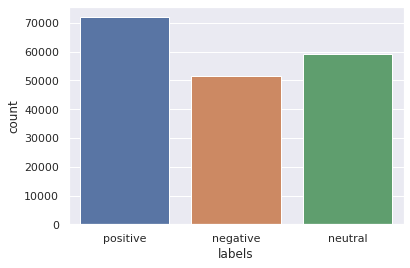

In [ ]:
sns.countplot(df['labels'])

*Tester la methode SentimentIntensityAnalyzer sur 3 exemples* 





In [ ]:
df1=pd.DataFrame()
df1['text']=["python is interepted language ","it's a good day","it's a bad day"]
sid = SentimentIntensityAnalyzer()
ps = lambda x : sid.polarity_scores(x)
sentiments_scores = df1.text.apply(ps)
sentiments_scores
sentiments_df = pd.DataFrame(data = list(sentiments_scores))
sentiments_df.head()
labelize = lambda x : 'neutral' if x==0 else ('positive' if x > 0 else 'negative')  
sentiments_df['labels'] = sentiments_df.compound.apply(labelize)
sentiments_df.head()
df1['labels']=sentiments_df['labels']
df1.head()

,text,labels
0,python is interepted language,neutral
1,it's a good day,positive
2,it's a bad day,negative


###  Nettoyage des tweets (Suppresssion des stop_words ,lemmatisation ...)

In [ ]:
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
tags = "@\S+|https?:\S+|http?:\S|[^A-Za-z]+"
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
words = ["people", "death", "case","today", "new", "pandemic", "u", "mask", "trump", "one", "died", "get", "health", "day", "covid", "time", "american", "crisis", "say", "need", "many", "risk", "dont", "due", "state", "virus", "country", "school", "like", "realdonaldtrump", "test"]
stop_words.update(words)

def preprocess_text(sentence, stem = True):
    
    sentence = re.sub(tags,' ', str(sentence).lower()).strip()
    text = []
    for word in sentence.split():
        
        if word not in stop_words:
            
            if stem:
                text.append(lemmatizer.lemmatize(word))
            else:
                text.append(word)
                
    return str(tokenizer.tokenize(" ".join(text)))

### Tester la methode preprocess_text 

In [ ]:
nltk.download('wordnet')
print(f"Orignal Text : {df.text[18]}")
print("\nAfter Preprocessed : \n")
dta = "this years was so bad ,it is you year"
print(f"Preprocessed Text : {preprocess_text(df.text[18])}")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Orignal Text : it is during our darkest moments that we must focus to see the lightaristotle

After Preprocessed : 

Preprocessed Text : ['darkest', 'moment', 'must', 'focus', 'see', 'lightaristotle']


In [ ]:
df.head()

,username,text,date,labels
0,96264,if i smelled the scent of hand sanitizers toda...,2020-07-25,positive
1,79755,hey yankees yankeespr and mlb wouldnt it have ...,2020-07-25,positive
2,79481,diane3443 wdunlap realdonaldtrump trump never ...,2020-07-25,negative
3,89034,brookbanktv the one gift has give me is an app...,2020-07-25,positive
4,19179,25 july media bulletin on novel coronavirusupd...,2020-07-25,positive


### Appliquer la methode preprocess_text sur la colonne 'text'

In [ ]:
df.text = df.text.map(preprocess_text)
df.head()

,username,text,date,labels
0,96264,"['smelled', 'scent', 'hand', 'sanitizers', 'so...",2020-07-25,positive
1,79755,"['hey', 'yankee', 'yankeespr', 'mlb', 'wouldnt...",2020-07-25,positive
2,79481,"['diane', 'wdunlap', 'never', 'claimed', 'hoax...",2020-07-25,negative
3,89034,"['brookbanktv', 'gift', 'give', 'appreciation'...",2020-07-25,positive
4,19179,"['july', 'medium', 'bulletin', 'novel', 'coron...",2020-07-25,positive


###Visualisation des mots frequents sur la colonne labels 

In [ ]:
positive_tweet = df[df['labels'] == 'positive']['text']
neutral_tweet = df[df['labels'] == 'neutral']['text']
negative_tweet = df[df['labels'] == 'negative']['text']
positive_tweet_list = positive_tweet.tolist()
negative_tweet_list = negative_tweet.tolist()
neutral_tweet_list = neutral_tweet.tolist()
pos_tokens = [token for line in positive_tweet_list  for token in line.split()]
neg_tokens = [token for line in negative_tweet_list  for token in line.split()]
neut_tokens = [token for line in neutral_tweet_list  for token in line.split()]
from collections import Counter
def get_tokens(docx,num=30):
    word_tokens = Counter(docx)
    most_common = word_tokens.most_common(num)
    result = dict(most_common)
    return result
most_common_pos_words = get_tokens(pos_tokens)
most_common_neg_words = get_tokens(neg_tokens)
most_common_neut_words = get_tokens(neut_tokens)

###Generation d'un barplot pour les tweets negatifs

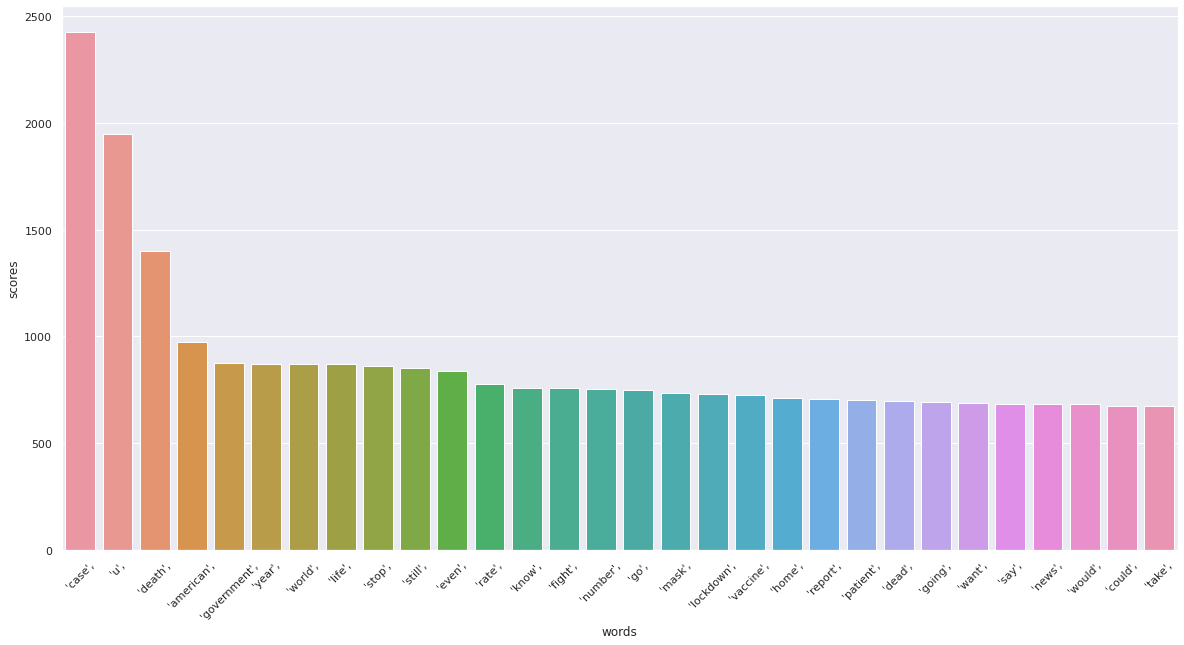

In [ ]:
neg_df = pd.DataFrame(most_common_neg_words.items(),columns=['words','scores'])
plt.figure(figsize=(20,10))
sns.barplot(x='words',y='scores',data=neg_df)
plt.xticks(rotation=45)
plt.show()

###Generation d'un barplot pour les tweets positifs

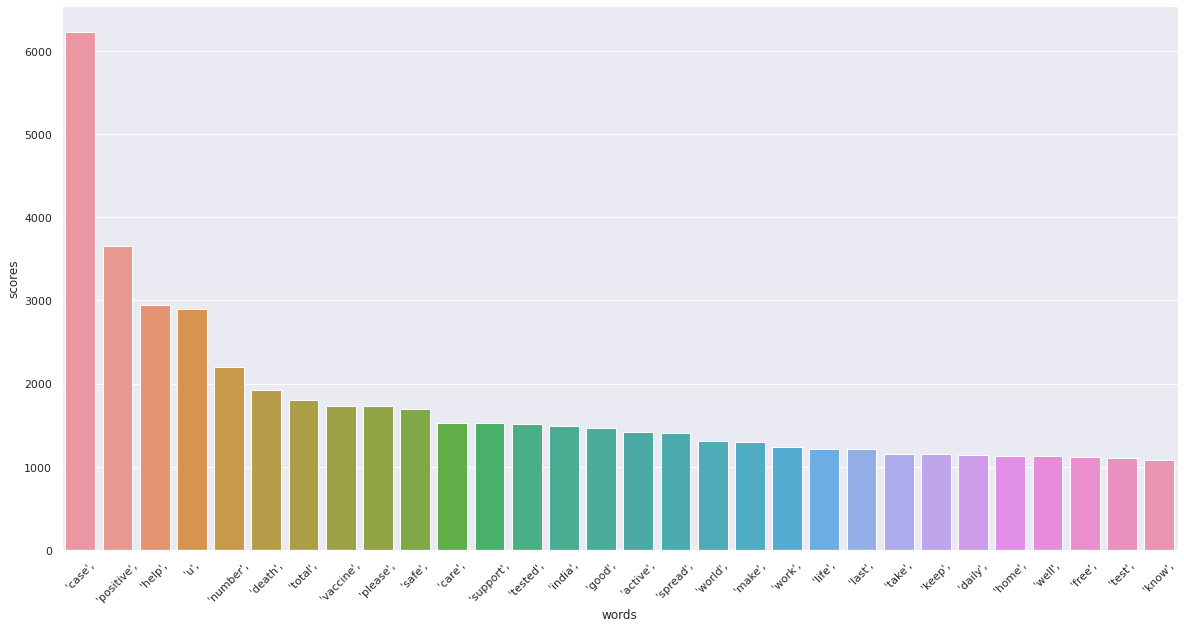

In [ ]:
pos_df = pd.DataFrame(most_common_pos_words.items(),columns=['words','scores'])
plt.figure(figsize=(20,10))
sns.barplot(x='words',y='scores',data=pos_df)
plt.xticks(rotation=45)
plt.show()

###Generation d'un barplot pour les tweets neutres

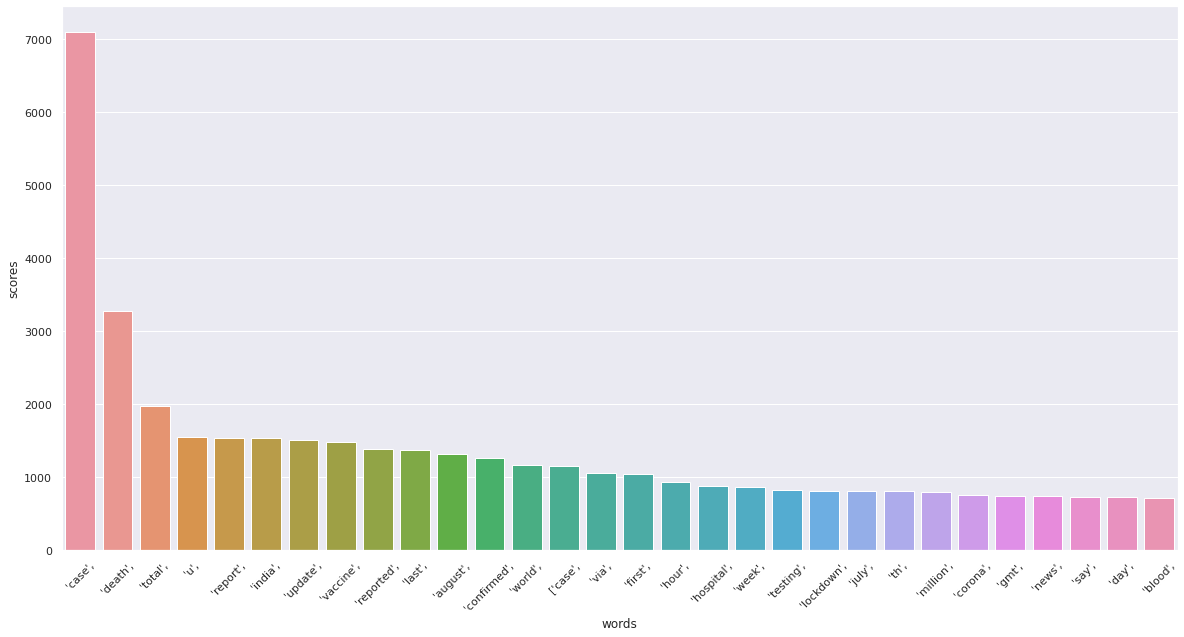

In [ ]:
neut_df = pd.DataFrame(most_common_neut_words.items(),columns=['words','scores'])
plt.figure(figsize=(20,10))
sns.barplot(x='words',y='scores',data=neut_df)
plt.xticks(rotation=45)
plt.show()

###Generation d'un wordcloud pour chaque categorie des tweets

In [ ]:
from wordcloud import WordCloud

In [ ]:
def plot_wordcloud(docx):
    plt.figure(figsize=(20,10))
    mywordcloud = WordCloud().generate(docx)
    plt.imshow(mywordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
pos_docx = ' '.join(pos_tokens)
neg_docx = ' '.join(neg_tokens)
neu_docx = ' '.join(neut_tokens)

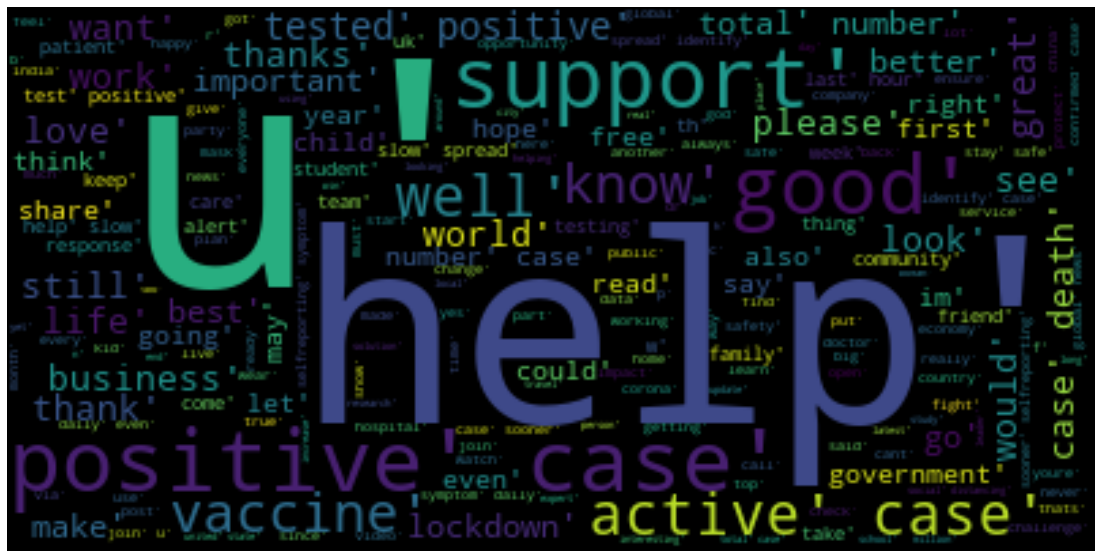

In [ ]:
plot_wordcloud(pos_docx)

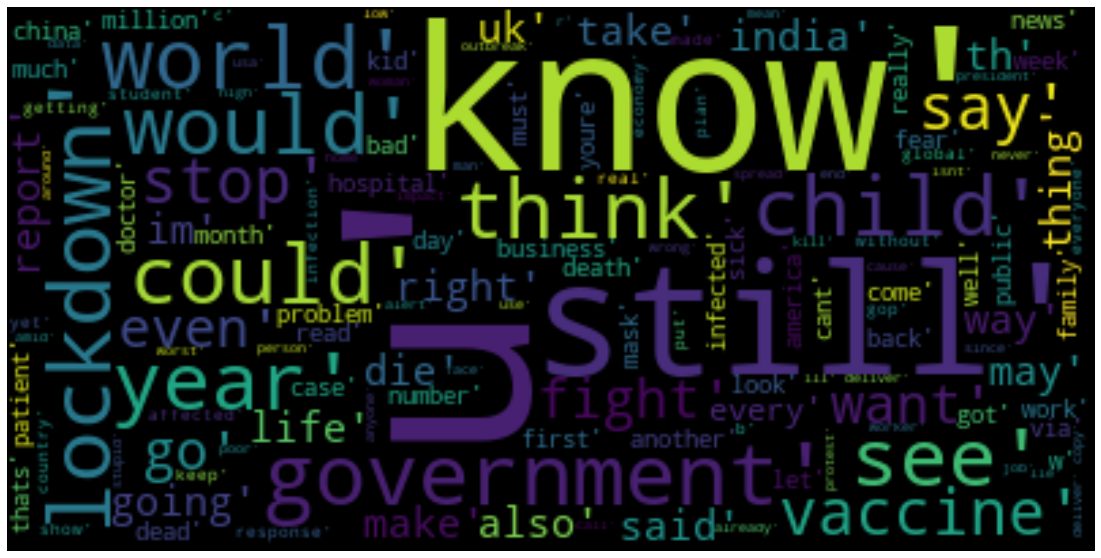

In [ ]:
plot_wordcloud(neg_docx)

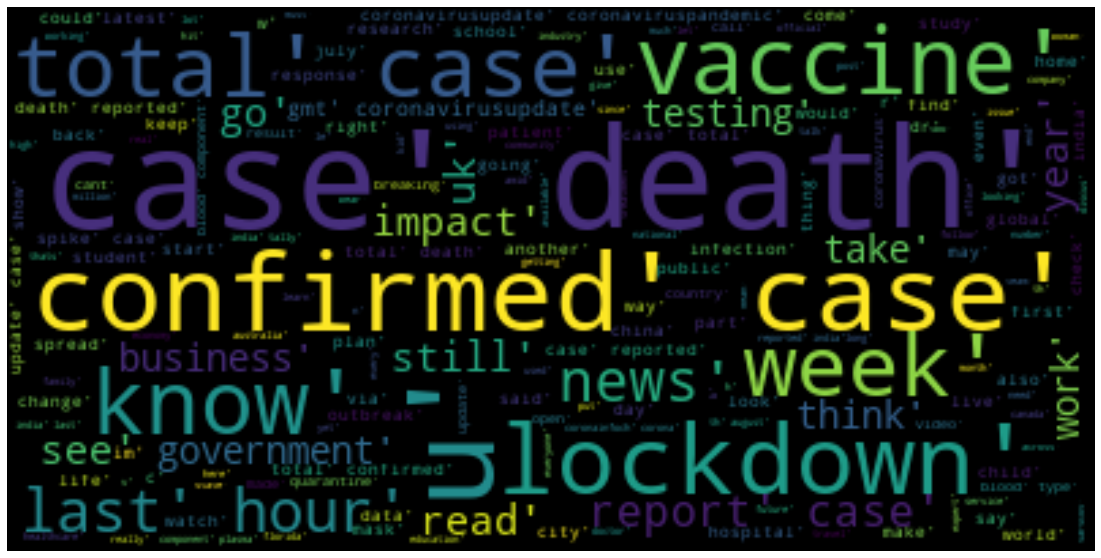

In [ ]:
plot_wordcloud(neu_docx)

###Analyse quotidienne des tweets sentimentaux de l année 2020

In [ ]:
data_agg = df[['username','date','labels']].groupby(['date','labels']).count().reset_index()
data_agg.columns = ['date','label','counts']
data_agg_2020 = data_agg.iloc[:77]

px.line(data_agg_2020,x='date',y='counts',color='label',title='Analyse quotidienne des tweets sentimentaux de l année 2020')

### Generation des modeles 

 ***Formater la colonne labels***

In [ ]:
le = LabelEncoder()
df.labels = le.fit_transform(df.labels)

In [ ]:
df.tail()

,username,text,date,labels
182610,26727,"['enter', 'replicate', 'cell', 'team', 'embl',...",2021-03-25,0
182611,61796,"['watch', 'drfaucis', 'thinking', 'happy', 'sm...",2021-05-06,2
182612,44593,"['newcomer', 'help', 'prevent', 'spread', 'ser...",2021-07-25,2
182613,14298,"['indian', 'economy', 'may', 'grow', 'moderate...",2021-08-25,2
182614,14298,"['nifty', 'slumped', 'negative', 'global', 'cu...",2021-03-16,2


In [ ]:
print("Samples per class {}".format(np.bincount(df.labels)))

Samples per class [51417 59232 71966]


**Partitionner le dataset en deux parties :train ,test **

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.labels, random_state=50, test_size=0.3)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(127830,) (54785,) (127830,) (54785,)


**Generation de la matrice term-Document**

In [ ]:
vect = CountVectorizer()

*Appliquer le modele sur X_train et X_test*

In [ ]:
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

### RandomForest 

****

In [ ]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit( X_train, y_train)

RandomForestClassifier()

**Prediction des valeurs de X_test pour le modele RandomForestClassifier**

In [ ]:
prediction=rf_classifier.predict(X_test)

**Creation de la matrice de confusion**

In [ ]:
print(confusion_matrix(y_test,prediction))
print(classification_report(y_test,prediction))

[[11434  1858  2257]
 [  287 17043   398]
 [ 1152  1077 19279]]
              precision    recall  f1-score   support

           0       0.89      0.74      0.80     15549
           1       0.85      0.96      0.90     17728
           2       0.88      0.90      0.89     21508

    accuracy                           0.87     54785
   macro avg       0.87      0.86      0.87     54785
weighted avg       0.87      0.87      0.87     54785



*classification_report retourne precision,recall,f1_score pour chaque categorie*

**Calculer le F1_score pour le modele ,C'est la valeur qu'on va utiliser  pour choisir le meilleur modele**

In [ ]:
f1_score(y_test,prediction,average='micro')

0.8716984576070093

Pour le modele RandomForestClassifier ,le F_Score est 0.8831979556447933

## LogisticRegression

In [ ]:
model = LogisticRegression(solver='newton-cg')
model.fit(X_train,y_train)
pred = model.predict(X_test)

**Creation de la matrice de confusion**

In [ ]:
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[12164  1684  1701]
 [  427 16915   386]
 [ 1428   936 19144]]
              precision    recall  f1-score   support

           0       0.87      0.78      0.82     15549
           1       0.87      0.95      0.91     17728
           2       0.90      0.89      0.90     21508

    accuracy                           0.88     54785
   macro avg       0.88      0.88      0.88     54785
weighted avg       0.88      0.88      0.88     54785



In [ ]:
f1_score(y_test, pred,average='micro')

0.8802226886921602

Pour le modele LogisticRegression ,le F_Score est 0.9006662407593319

# ARBRE DE DECISION 

In [ ]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
pred=clf.predict(X_test)

**Creation de la matrice de confusion**

In [ ]:
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[11409  1424  2716]
 [  853 16313   562]
 [ 2037   715 18756]]
              precision    recall  f1-score   support

           0       0.80      0.73      0.76     15549
           1       0.88      0.92      0.90     17728
           2       0.85      0.87      0.86     21508

    accuracy                           0.85     54785
   macro avg       0.84      0.84      0.84     54785
weighted avg       0.85      0.85      0.85     54785



In [ ]:
f1_score(y_test, pred,average='micro')

0.8483709044446472

Pour le modele DecisionTreeClassifier ,le F_Score est 0.8723555717805969

**The multinomial Naive Bayes classifier**

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
pred=mnb.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[11471  1056  3022]
 [ 2398 11412  3918]
 [ 2343   837 18328]]
              precision    recall  f1-score   support

           0       0.71      0.74      0.72     15549
           1       0.86      0.64      0.74     17728
           2       0.73      0.85      0.78     21508

    accuracy                           0.75     54785
   macro avg       0.76      0.74      0.75     54785
weighted avg       0.76      0.75      0.75     54785



In [ ]:
f1_score(y_test, pred,average='micro')

0.7522314502144748

**Parmis les modèles crées ,On a choisi le modèle LogisticRegression ,vue qu'on a un F_score trop élevé par rapport à les autres modeles**

**Word2Vec**

In [ ]:
model = Word2Vec(tokenized_tweet, size=200,  window=5)
model.train(tokenized_tweet, total_examples= len(df['text']), epochs=20)

(44367501, 57860600)

In [ ]:
 model.most_similar(positive="covid")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('coronaoutbreak', 0.42220067977905273),
 ('covid19', 0.40221458673477173),
 ('jammuparivartan', 0.3965965509414673),
 ('togetheragainstcovid19', 0.3657146096229553),
 ('coronavirus', 0.3619309067726135),
 ('besafe', 0.34876078367233276),
 ('wuflu', 0.3410680890083313),
 ('klenapp', 0.3409370183944702),
 ('chinesenoodlearmy', 0.33971303701400757),
 ('coronavaccine', 0.33830761909484863)]

**FastText**

In [ ]:
from gensim.models import FastText

print("Training a Gensim FastText model")
model = FastText(sentences=tokenized_tweet, size = 200, window = 2) # workers = workers, 
print("Training complete")

Training a Gensim FastText model
Training complete


In [ ]:
 model.most_similar(positive="covid")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('covidnz', 0.9830600023269653),
 ('covid1', 0.9791930913925171),
 ('covidbc', 0.9772602319717407),
 ('covidrehab', 0.9722570776939392),
 ('covi19', 0.9719939827919006),
 ('covi', 0.9700755476951599),
 ('covid19de', 0.9691720604896545),
 ('covidvic19', 0.9676290154457092),
 ('covid19ke', 0.967035174369812),
 ('covid19lk', 0.9665154218673706)]

In [ ]:
def word_vector(tokens, size):
     vec = np.zeros(size).reshape((1, size))
     count = 0.
     for word in tokens:
         try:
             vec += model[word].reshape((1, size))
             count += 1.
         except KeyError: # handling the case where the token is not in vocabulary
                         
             continue
     if count != 0:
         vec /= count
     return vec

In [ ]:
fasttext_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    fasttext_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
fasttext_df = pd.DataFrame(fasttext_arrays)
fasttext_df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



(182615, 200)

In [ ]:
fasttext_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.329869,0.526957,-0.339263,-0.665160,0.168049,-0.153659,0.615968,-0.227660,0.811757,-0.993475,0.359542,-0.597100,0.082151,0.492599,0.208607,1.511865,0.624781,-0.067858,-0.081774,0.312586,0.135494,-0.895824,0.816808,0.062149,-0.491066,0.317097,1.299514,-0.731433,-0.107824,-0.135592,0.177970,0.146995,-0.419553,-0.884235,-1.116255,0.386335,0.001036,-0.558646,-0.277891,-0.379190,...,0.110149,-0.370768,-0.258287,-0.968794,0.763218,0.112711,-0.628599,-0.521534,-0.681016,-0.624922,0.271422,0.285747,-0.125143,-0.303219,-0.561051,-0.142884,-0.426084,-0.507534,0.081226,-0.030445,0.152552,-0.010331,0.645436,-0.065292,-0.119362,0.078061,0.071281,-0.354377,0.610956,0.120847,-0.155035,-0.439680,0.030324,-0.535959,-0.401460,0.226663,0.799633,0.121887,-0.074097,-0.206809
1,-0.750497,0.131767,-0.287711,-0.171911,-0.302927,-0.404508,-0.047033,-0.751215,0.545584,-0.631318,-0.181348,-0.018212,0.023167,-0.240282,0.064337,0.343857,0.962663,0.347320,0.169803,0.729093,-0.060189,-0.433579,0.317520,0.396405,0.286572,0.228097,1.147527,-0.735934,0.120933,0.085107,0.812572,0.299923,-0.092030,-1.023822,-0.443591,0.076670,0.058553,0.136804,0.144045,-0.516386,...,0.197521,-0.266836,-0.137236,-0.841681,0.564649,0.028279,-0.153241,-0.315254,-0.400497,-0.346214,0.010864,0.088096,0.032089,-0.071135,0.525084,-0.504496,-0.200626,-0.147682,0.014326,-0.309927,0.444676,-0.357675,0.884892,-0.394846,-0.078071,0.285847,-0.258452,-0.727770,0.584277,-0.145491,0.115745,0.259490,0.210042,-0.346605,0.098718,0.463765,0.691568,0.097143,-0.365789,-0.359302
2,-0.192986,-0.003268,-0.332111,-0.243134,-0.288661,-0.145648,0.307504,-0.704506,0.908274,-0.653675,-0.365091,0.143120,-0.161008,-0.191197,0.066335,0.640282,0.627995,0.650032,0.222981,0.716507,-0.086037,-0.291085,0.356825,0.722603,0.288879,0.027046,1.373070,-0.673349,-0.296249,-0.198964,0.572529,0.291747,-0.452231,-0.355094,-0.721419,-0.032420,-0.065794,-0.240264,-0.115580,-0.355230,...,-0.049494,-0.247270,-0.248636,-0.623063,0.813194,-0.359301,-0.293160,-0.410336,-0.430518,-0.243851,0.260691,0.191286,-0.024175,-0.209815,-0.076485,-0.336095,-0.401780,0.006332,0.020794,-0.356274,0.143210,-0.458182,1.184823,-0.674163,-0.119934,0.359323,-0.096741,-0.548338,0.858864,-0.180680,0.184742,-0.132108,0.334710,-0.405334,0.032037,0.391570,0.774250,0.108251,-0.108284,-0.539993
3,-0.708536,-0.080637,0.002453,-0.209088,-0.205107,-0.211274,-0.464363,-0.451146,0.492472,-0.712387,-0.183485,-0.248901,0.053285,-0.213755,-0.221706,0.212134,0.828060,0.432850,0.433190,0.040009,0.285168,-0.429104,0.046620,0.496105,0.303367,0.414942,0.840886,-0.713313,-0.006467,0.147803,0.673843,0.101010,0.159898,-0.102235,-0.861681,-0.020101,0.032032,0.171187,-0.030659,-0.267439,...,-0.021790,-0.201416,-0.022707,-0.581352,0.380459,0.172434,0.362715,-0.058261,-0.602932,-0.086022,0.227917,0.106579,0.078344,0.019450,-0.209783,-0.185576,-0.316378,0.041199,0.196419,-0.173522,0.485999,0.085367,0.477486,-0.261709,0.071841,0.153430,-0.141873,-0.538790,1.054713,0.224327,0.463520,-0.599878,0.010545,-0.285932,-0.232306,0.505877,0.644157,-0.262695,-0.124115,-0.058003
4,-0.047597,-0.079937,-0.291548,0.388169,0.078709,0.006559,-0.146979,-0.183626,-0.325426,-0.126543,-0.422792,0.092261,-0.115950,-0.153367,-0.688204,-0.233528,0.010662,0.052984,0.211456,0.051145,0.265474,-0.307088,-0.084306,0.177781,0.327551,0.108074,0.509339,-0.249900,0.162226,0.413529,-0.319513,0.061296,0.312256,-0.496651,-0.521551,0.246593,0.058214,-0.075091,-0.617813,0.194559,...,0.424552,-0.158101,0.351187,-0.745035,-0.066106,-0.027702,0.202341,0.383288,0.159429,0.102351,-0.051767,-0.231378,0.024016,-0.287324,-0.763334,-0.021363,-0.187328,-0.167744,0.039817,-0.347191,0.401310,0.311928,0.147252,0.483539,0.392032,0.321079,0.345722,0.562411,

In [ ]:
from sklearn.model_selection import train_test_split
train_w2v = fasttext_df.iloc[:(182615//3)*2,:]
test_w2v = fasttext_df.iloc[(182615//3)*2:,:]
print(train_w2v.shape)
print(test_w2v.shape)
print( df['labels'].shape)
_, _, ytrain, yvalid = train_test_split(fasttext_df, df['labels'],random_state=42,test_size=0.3)
print(train_w2v.shape, df['labels'].shape)

(121742, 200)
(60873, 200)
(182615,)
(121742, 200) (182615,)


In [ ]:
print(fasttext_df.shape)

(182615, 200)
